# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

In [2]:
import skimage.io
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import closing, square, binary_erosion, binary_dilation, binary_opening, binary_closing, disk, remove_small_holes
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from skimage.filters import median, gaussian
from skimage.segmentation import active_contour
from scipy.ndimage import gaussian_laplace
from matplotlib.colors import ListedColormap
from colorsys import hls_to_rgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Brain image visualization

Let us first visualize the brain and try to get an idea how to solve the problem.

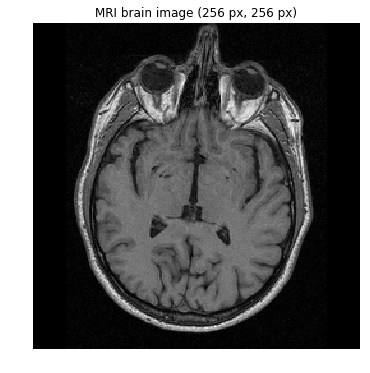

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
num_pixel = im_h*im_w

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

We can see that the objects on the image have higher intensity than the background. To understand how gray levels are distributed over pixels, let us plot a histogram of the image.

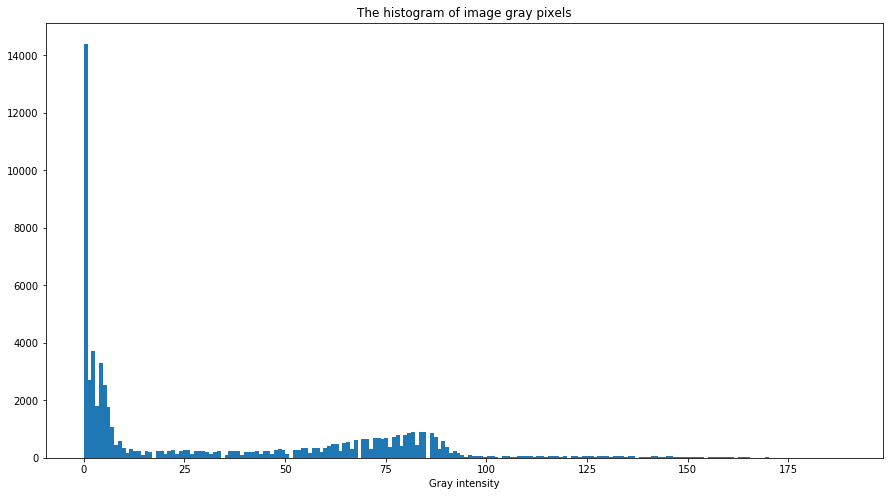

In [4]:
nbins = 200

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(brain_im.ravel(), bins=nbins)
ax.set_xlabel('Gray intensity')
ax.set_title('The histogram of image gray pixels');

As you may see, we have a *trimodal* distribution with two very close peaks corresponding to the inner part of the brain and the skull (region between 50 and 100 gray intensities) and one peak corresponding to the background (the peak near zero). In addition, we observe the noise that skews the data between peaks.

Using this information we could separate the inner part of the brain by defining manually two thresholds, which would isolate the moderate gray intensity parts of the image that should correspond to the desired object. As there is noise in the image, we may also isolate pixels that are not associated with the brain. That is why we should first label all isolated parts of the image and then choose the biggest one, which corresponds to the inner part of the brain. To achieve that we will implement the *region growing* method explained in the lecture. This approach is described in the [section 1.2](#region).

We can also use *contour detection* methods to identify the edges of the objects and highlight the desired one. #ADD DESCRIPTION This approach is described in the [section 1.3](#contour).

Given the notion that the noise is normally distributed, we could also fit the histogram curves to the Gaussian function and make a probabilistic model that could assign each pixel to specific gaussian according to the likelihood of this assignment. We will use [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) object from scikit-learn that allows you to construct the model in an quick and effective way. This approach is described in the [section 1.4.1](#GaussianMixture).

Additionally, we can use [`kMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method to identify the desired objects. Knowing the number of the clusters (objects), we could easily label them and identify the biggest one corresponding to the brain. This approach is described in the [section 1.4.2](#clustering).

Finnaly, in the [section 1.5](#results) we compared all discussed methods regarding to initial task of computing the size of the brain in pixels. 

<a id='region'></a>

### 1.2 Double thresholding + Region growing

First, let us implement the region growing method to label the identified objects. In order to do that we will define 2 supporting functions that allow us the get the neighbours of the pixel - `get_neighbours()`, and get the region that was grown from the certain starting point - `grow()`.

In [5]:
def get_neighbours(pixel):
    """
        Return 4 neighbours of the input pixel.
        
        Parameters
        ----------
        pixel : list of length 2
            The coordinates of the pixel
            
        Returns
        -------
        list of 4 tuples of length 2
            The 4 pixel coordinates of the neighbours.
    """ 
    
    return [(pixel[0] + 1, pixel[1]), 
            (pixel[0] - 1, pixel[1]),
            (pixel[0], pixel[1] + 1),
            (pixel[0], pixel[1] - 1)]

def grow(pixel_to_start, mask, visited):
    
    """
        Return region starting from pixel_to_start. 
        The region should correspond to mask that contain isolated regions of interest.
        
        Parameters
        ----------
        pixel_to_start : list of length 2
            The coordinates of the starting pixel.
        mask : array of shape (image_height, image_width)
            The logical matrix which mark the regions of interest.
        visited : list of lists of length 2
            The list that contains all visited pixels.
            
        Returns
        -------
        list of lists of length 2
            The list of pixels of the grown region.
    """
    
    stack = [pixel_to_start]
    region = [pixel_to_start]
    visited[pixel_to_start] = 1

    while len(stack):
        
        # Pick a pixel
        cur_pixel = stack.pop()

        pixels_to_check = get_neighbours(cur_pixel)
        
        # Check if neighbours are not visited and correspond to mask
        pixels_from_region = [pixel for pixel in pixels_to_check if mask[pixel] and not visited[pixel]]
        
        # Update containers
        stack.extend(pixels_from_region)
        for pixel in pixels_from_region:
            visited[pixel] = 1
        region.extend(pixels_from_region)
        
    return region
        
def region_growing(mask):
    
    """
        Region growing method that finds the connected objects 
        in the image indicated by mask and labels them.
        
        Parameters
        ----------
        mask : array of shape (image_height, image_width)
            The logical matrix which mark the regions of interest.
            
        Returns
        -------
        list of lists of lists of length 2
            The list that contains all grown regions.
    """
    
    regions = []
    visited = np.zeros(mask.shape)
    
    while True: # Each iteration is aimed to process one region
        # Search pixels not attached for any processed region
        pixels_to_grow = mask * (1 - visited)
        
        # If all pixels from the mask are labeled, algorithm identified all objects
        if len(pixels_to_grow[pixels_to_grow > 0]) == 0:
            break
            
        X, Y = np.where(pixels_to_grow > 0)
        pixel_to_start = (X[0], Y[0]) # Pixel from unknown region
        
        region = grow(pixel_to_start, mask, visited)
        regions.append(region)
         
    return regions

Now let us choose manually two thresholds that could extract the inner part of the brain and filter out the skull and the background. By looking at the histogram and the image we could conclude that brighter pixels with gray intensities around 95 correspond to the skull and dark pixels with gray intensities below 65 correspond to the background.

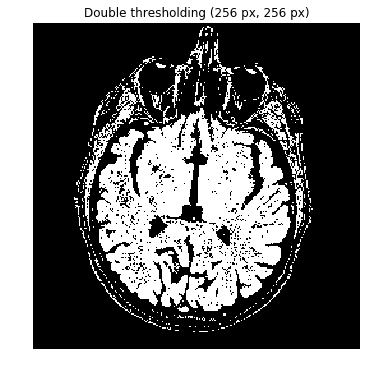

In [6]:
upper_threshold = 90  # The threshold to exclude bright "skull" pixels
lower_threshold = 60 # The threshold to exclude "background" pixel

# Create a mask that indicate only the inner part of the brain
brain_mask_double = [[(pixel > lower_threshold) and (pixel < upper_threshold) 
                             for pixel in line] for line in brain_im] 

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_mask_double, cmap='gray')
ax.set_title('Double thresholding ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

We may note that the with our manual thresholding we isolated both the skull and the brain itself. We can work with that, as we extract the latter by finding the biggest isolated region. However, we should apply filtering methods as the image appears to be noisy. We will use median filter because professor really likes this one.

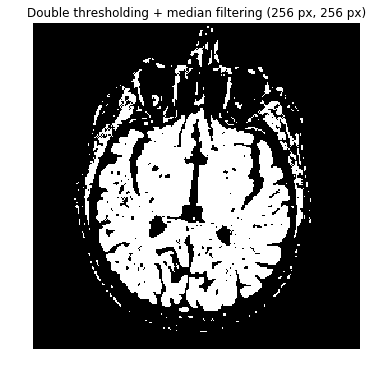

In [7]:
brain_mask_double_filtered = median(brain_mask_double, selem=disk(1))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_mask_double_filtered, cmap='gray')
ax.set_title('Double thresholding + median filtering ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

Now we can apply region growing method to get all connected regions and then take the biggest one which will be the brain.

235 connected regions were found


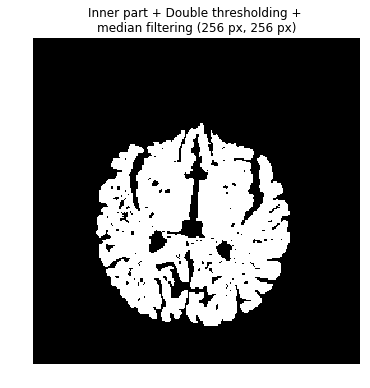

In [8]:
# Getting all connected regions
regions = region_growing(brain_mask_double_filtered)
print(f"{len(regions)} connected regions were found")

# Getting the brain region knowing that it is the biggest region
inner_brain_region = max(regions, key=len)

inner_brain_mask_double_filtered = np.full(brain_im.shape, fill_value=False)
for coords in inner_brain_region:
    inner_brain_mask_double_filtered[coords] = True
    
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(inner_brain_mask_double_filtered, cmap='gray')
ax.set_title('Inner part + Double thresholding + \nmedian filtering ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

Let us remove the holes inside the brain.

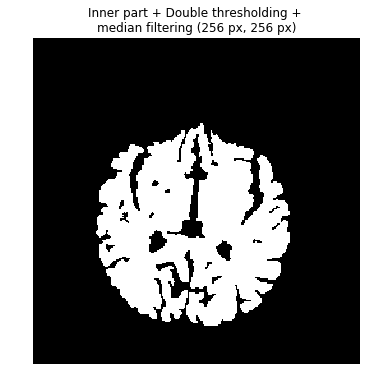

In [9]:
holes_threshold = 10

inner_brain_double = remove_small_holes(inner_brain_mask_double_filtered, area_threshold=holes_threshold)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(inner_brain_double, cmap='gray')
ax.set_title('Inner part + Double thresholding + \nmedian filtering ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

Let us combine all pictures together so that we can see the whole workflow.

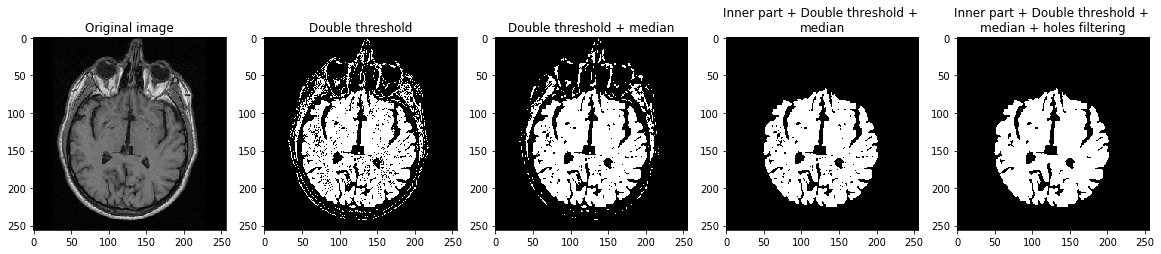

In [10]:
titles = ["Original image", "Double threshold", "Double threshold + median", 
          "Inner part + Double threshold + \nmedian", "Inner part + Double threshold + \nmedian + holes filtering"]

masks = [brain_im, 
         brain_mask_double,
         brain_mask_double_filtered,
         inner_brain_mask_double_filtered,
         inner_brain_double]

fig, ax = plt.subplots(1, len(masks), figsize=(20, 10))

for i in range(len(masks)):
    ax[i].imshow(masks[i], cmap='gray')
    ax[i].set_title(titles[i])

Now we can calculate the size of the inner part of the brain.

In [11]:
brain_size = np.sum(np.sum(inner_brain_double))
print('The size of the brain is: {} pixels'.format(brain_size))

The size of the brain is: 15299 pixels


<a id='contour'></a>

### 1.3 Contour detection

First, we try the active contour method given by scikit-image, which returns an decent result.

The area is 22838 pixels


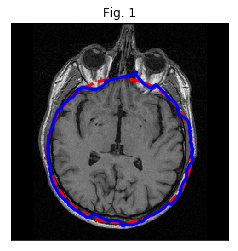

In [24]:
def area(polygon):
    x, y = tuple(list(zip(*polygon)))
    return len(skimage.draw.polygon(x, y)[0])

s = np.linspace(0, 2*np.pi, 400)
r = 150 + 85*np.sin(s)
c = 128 + 85*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(median(brain_im, disk(2)),
                       init,
                       alpha=.0005, # Snake length shape parameter. Higher values makes snake contract faster. 
#                        beta=1, # Snake smoothness shape parameter. Higher values makes snake smoother 
#                        gamma=0.1, # Explicit time stepping parameter.
                       coordinates='rc')

print("The area is {} pixels".format(area(snake)))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(brain_im, cmap='gray')
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Fig. 1")

plt.show()

As we can see in the top of the Fig. 1, the result is not very precise, and even by tweaking all the parameters we couldn't get a more detailed contour.

Therefore we use a more simplistic method to extract the contours.

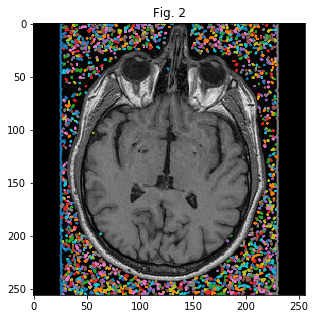

In [25]:
# Get contours
contours = skimage.measure.find_contours(brain_im, level=1)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(brain_im, cmap='gray')
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title("Fig. 2")
_ = plt.plot()

Here we clearly see in Fig. 2 that there is too much noise in the background.

Therefore we decide to apply a Laplacing of Gaussian filter to smooth out the noise and filter out contours we are not interested in.

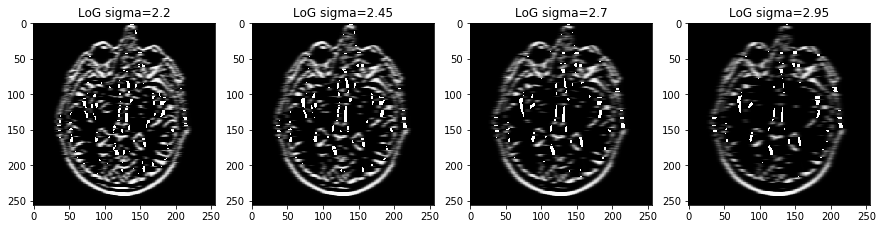

In [26]:
figures_count = 4
fig, ax = plt.subplots(1, figures_count, figsize=(15, 10))

for i in range(figures_count):
    sigma = i/(figures_count) + 2.2
    LoG = gaussian_laplace(brain_im, sigma=sigma)
    ax[i].imshow(LoG, cmap='gray')
    ax[i].set_title("LoG sigma={}".format(sigma))

plt.show()

Then we extract the contours from the filtered image, select the longest one and compute its area.

The area is 19893 pixels


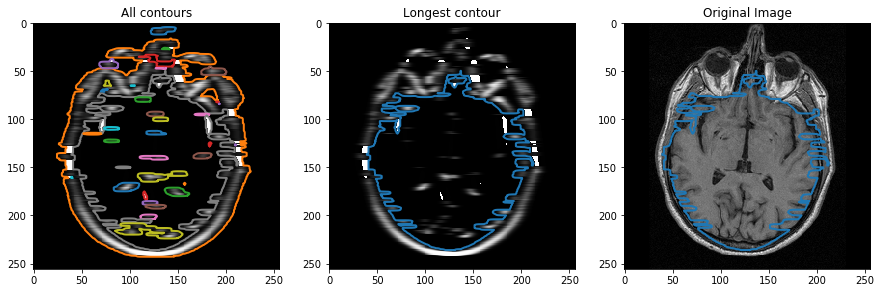

In [27]:
# Get the contours for a Laplacing of Gaussian
LoG = gaussian_laplace(brain_im, sigma=3.6)
contours = skimage.measure.find_contours(LoG, level=2.5)

# Get the longest contour
longest_contour = sorted(contours, key=lambda contour: len(contour))[-1]
print("The area is {} pixels".format(area(longest_contour)))

# Draw
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

# Show all contours
ax[0].imshow(LoG, cmap='gray')
for n, contour in enumerate(contours):
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[0].set_title("All contours")

# Show only widest contour
ax[1].imshow(LoG, cmap='gray')
ax[1].plot(longest_contour[:, 1], longest_contour[:, 0], linewidth=2)
ax[1].set_title("Longest contour")

# Show only widest contour on original image
ax[2].imshow(brain_im, cmap='gray')
ax[2].plot(longest_contour[:, 1], longest_contour[:, 0], linewidth=2)
ax[2].set_title("Original Image")

plt.show()

### 1.4 Additional methods

<a id='GaussianMixture'></a>

#### 1.4.1 GaussianMixture model

Now we will try to construct a probability model based on fitting our histogram data to the mixture of gaussians. Let us first have a closer look at the data distribution near 80, to get an idea about the number of gaussians. In the [section 1.2](#region) we observed that our image is more noisy, than we thought before. Thus we will apply the median filtering before downstream analysis.

In [ ]:
brain_im_median = median(brain_im, selem=disk(1))

nbins = 50

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(brain_im_median.ravel(), bins=nbins, density=True)
ax.set_xlabel('Gray intensity')
ax.set_title('The histogram of image gray pixels')
ax.set_ylim([0, 0.05]);

In our opinion, we observe 4 gaussians: the first one is close to zero, the second has the mean near 25, the third one has the mean near 75, and the fourth one near 125. We will try to fit all gaussians to get a better representation of different clusters in the image. If the brain is divided into two clusters we will merge them and obtain the desired region.

As described above, we will use [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) implemented as a part of scikit-learn library.

In [ ]:
def get_distinct_colors(n):
    """
        Additional function to create a list and a colormap of distinct colors for better visualization.
        
        Parameters
        ----------
        n : int
            The number of distinct colors
            
        Returns
        -------
        colors : list of RGB values
            The list that contains n distinct colors.
        colormap : matplotlib.colors.ListedColormap object
            The colormap with n distinct colors
    """

    colors = []

    for i in np.arange(0., 360., 360. / n):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(hls_to_rgb(h, l, s))
        
    cmap = ListedColormap(colors)

    return colors, cmap

In [ ]:
nbins=50
number_of_gaussians = 4

# Creating and fitting GaussianMixture model
gaus_mix_segm = GaussianMixture(n_components=number_of_gaussians)
brain_im_gaussian_clustered = gaus_mix_segm.fit_predict(brain_im_median.reshape(num_pixel, 1)).reshape(im_h, im_w)

# Extracting the parameters of the gaussians
weights = gaus_mix_segm.weights_.flatten()
mu = gaus_mix_segm.means_.flatten()
sigma = np.sqrt(gaus_mix_segm.covariances_.flatten())

# Get the list of distinct colors and the colormap with the same colors
colors, cmap = get_distinct_colors(number_of_gaussians)

# Plotting the brain image and the histogram with fitted gaussian curves
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(brain_im_gaussian_clustered, cmap=cmap)
ax[0].set_title('Clustered brain image \nthe colors correspond to the gaussian ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].hist(brain_im_median.ravel(), bins=nbins, density=True)
ax[1].set_xlabel('Gray intensity')
ax[1].set_title('The histogram of image gray pixels')

grid_x = np.linspace(brain_im_median.reshape(num_pixel, 1).min(), 
                     brain_im_median.reshape(num_pixel, 1).max(), 
                     200)

for i in range(number_of_gaussians):
    gauss_i = lambda x: norm.pdf(x, loc=mu[i], scale=sigma[i])
    gaussian_i = weights[i]*gauss_i(grid_x)
    ax[1].plot(grid_x, gaussian_i, lw=4, color=colors[i], label='{}-th gaussian'.format(i+1))

ax[1].legend()
ax[1].set_ylim([0, 0.05]);

We can conclude that the green area is the part that we want extract. However, we still have green regions near the eyes and in the skull. In order to filter these areas out we could again perform the *region growing* method and extract the biggest region. Let us have a better look at the green area.

In [ ]:
_, counts = np.unique(brain_im_gaussian_clustered, return_counts=True)
brain_cluster_ind = sorted(range(len(counts)), key=lambda ind: counts[ind], reverse=True)[1]
print(f"We assume that brain is the second largest segment in image. Thus index of brain's cluster is {brain_cluster_ind}.")

In [ ]:
from matplotlib.patches import Circle

# Extracting the green region
brain_mask_gaussian = brain_im_gaussian_clustered == brain_cluster_ind

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_mask_gaussian, cmap='gray')
ax.set_title('Inner part + Double thresholding + \nmedian filtering ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

# Highlighting the problematic part
circ = Circle((160, 80), 10, fill=False, color='r')
ax.add_patch(circ);

Before applying the *region growing* method, we should note that inside the green region there is a connection between the inner part of the brain and the eye region (this connection is highlighted on the image above). This will spoil the mask if we apply *region growing*. To erase this connection we could use *morphological opening*, which was explained in the second lecture.

Next cell will first do the morphological opening, then we will extract the biggest part of the green region by using the *region growing* method. After that we will show the whole workflow by visualizing all images from the start.

In [ ]:
# Applying the morphological opening for binary matrix
brain_mask_gaussian_opened = binary_opening(brain_mask_gaussian)

regions = region_growing(brain_mask_gaussian_opened)
print(f"{len(regions)} shapes were found")

# Getting the brain region knowing that it is the biggest region
inner_brain_region_coords = max(regions, key=len)

inner_brain_gaussian = np.full(brain_im.shape, fill_value=False)
for coords in inner_brain_region_coords:
    inner_brain_gaussian[coords] = True

titles = ["Original image", 
          "Median filter on the brain image",
          "GaussianMixture model \nvisualizing on the green part of the brain", 
          "Morphological opening", 
          "Inner part + morphological opening"]

masks = [brain_im, 
         brain_im_median,
         brain_mask_gaussian,
         brain_mask_gaussian_opened,
         inner_brain_gaussian]

fig, ax = plt.subplots(1, len(masks), figsize=(20, 10))

for i in range(len(masks)):
    ax[i].imshow(masks[i], cmap='gray')
    ax[i].set_title(titles[i])

Now we can calculate the size of the brain.

In [ ]:
brain_size = np.count_nonzero(inner_brain_gaussian)
print('The size of the brain is: {} pixels'.format(brain_size))

<a id='clustering'></a>

#### 1.4.2 Clustering

Another way to segment image is use clusterisation techniques. It is possible to either consider both combination of pixel's (x, y) coordinates and pixel's value as features or only last one. Using only pixel's value showed better result in combination with [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering.

In [13]:
# Let's obtain feature matrix. It will be of size: (256*256, 3) 
feature_matrix_v = np.array([[brain_im[i, k]] for i in range(brain_im.shape[1]) for k in range(brain_im.shape[0])])
feature_matrix_xyv = np.array([[i, k, brain_im[i, k]] for i in range(brain_im.shape[1]) for k in range(brain_im.shape[0])])

In [14]:
clustering_method_names = ["K-means 2 clusters", 
                           "K-means 3 clusters", 
                           "K-means 4 clusters",
                           "K-means 5 clusters"]

In [15]:
clustering = [KMeans(n_clusters=2, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=3, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=4, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=5, random_state=42).fit(feature_matrix_v)]

In [16]:
brain_im_clustered = [clustered.labels_.reshape(im_h, im_w) for clustered in clustering]

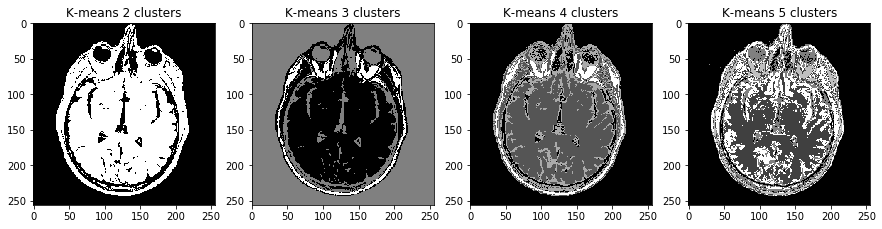

In [17]:
fig, ax = plt.subplots(1, len(brain_im_clustered), figsize=(15, 8))

for i in range(len(brain_im_clustered)):
    ax[i].imshow(brain_im_clustered[i], cmap='gray')
    ax[i].set_title(clustering_method_names[i])

As we can see K-means with 4 clusters shows the best result since it separates region of our interest from skull.

In [18]:
best_clustering_ind = 2

In [19]:
_, counts = np.unique(brain_im_clustered[best_clustering_ind], return_counts=True)
brain_cluster_ind = sorted(range(len(counts)), key=lambda ind: counts[ind], reverse=True)[1]
print(f"We assume that brain is the second largest cluster in image. Thus index of brain's cluster is {brain_cluster_ind}.")

We assume that brain is the second largest cluster in image. Thus index of brain's cluster is 1.


In [20]:
mask_kmeans = brain_im_clustered[best_clustering_ind] == brain_cluster_ind

regions = region_growing(mask_kmeans)
print(f"{len(regions)} shapes were found")

brain_region_coords = max(regions, key=len)

brain_mask_kmeans = np.full(brain_im.shape, fill_value=False)
for coords in brain_region_coords:
    brain_mask_kmeans[coords] = True

536 shapes were found


<a id='results'></a>

### 1.5 Results

Now lets compare all results and calculate brain sizes

In [21]:
titles = ["Original image", "Double threshold", "Gaussian Mixture model", "K-means clustering"]

images = [brain_im]
masks = [inner_brain_double,
         inner_brain_gaussian,
         brain_mask_kmeans
         ]

images += masks

fig, ax = plt.subplots(1, len(images), figsize=(15, 10))

for i in range(len(masks)):
    print(f"Method: {titles[i + 1]:40s} brain's size: {np.count_nonzero(masks[i])} pixels")
        
for i in range(len(images)):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])

NameError: name 'inner_brain_gaussian' is not defined

As we can see developed methods showed pretty much similar results. Thus let's use them as ensemble: resulting size will be average among all obtained ones.

In [22]:
brain_size = int(np.mean([np.count_nonzero(mask) for mask in masks]))

In [33]:
np.std([np.count_nonzero(mask) for mask in masks])

175.60625147059986

In [34]:
error = None # TODO: Estimate error

In [35]:
print(f"Brain's size is {brain_size} +- {error} pixels.")

Brain's size is 15459 +- None pixels.


## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [36]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


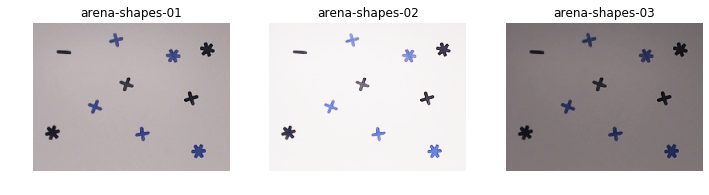

In [37]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

<a id='task22'></a>

### 2.2 Number of shapes of each color
Add your implementation and discussion

As first step we will try to distinguish foreground (shapes) from background. For that we will use contour based methods, namely Canny filter.

In [38]:
ind = 2 # Choose which image to process

In [39]:
image = images[ind]

In [40]:
grayscale = rgb2gray(image) * 255

In [41]:
edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection

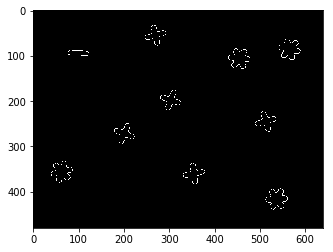

In [42]:
plt.imshow(edges, cmap="gray")
plt.show()

Great, now we have edges. Method worked relatively good even with default parameters. One reason for it is that source image has quite low level of noise.

Now we have to fill holes in shapes. For that we will use mathematical morphology methods. We will do closing with increasing size of structuring element till holes will be fully filled.

In [43]:
square_size = [5, 10, 20, 30, 40, 50]
mask_similarity_threshold = 0.999

shapes_mask = closing(edges, selem=square(square_size[0]))
for size in square_size[1:]:
    new_shapes_mask = closing(edges, selem=square(size))
    if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
        break
    shapes_mask = new_shapes_mask

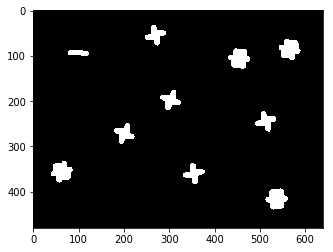

In [44]:
plt.imshow(shapes_mask, cmap="gray")
plt.show()

Now lets store pixels of each shape. For that we will use region growing method implemeneted in first part.

In [45]:
%time regions = region_growing(shapes_mask)
print(f"{len(regions)} shapes were found")

Wall time: 183 ms
10 shapes were found


Now we can use all pixels from region to calculate mean value

In [46]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.17824773, 60.11782477, 88.85498489],
       [36.35939553, 33.80617608, 39.32851511],
       [57.66644866, 59.76062786, 89.57030739],
       [39.12398374, 36.46341463, 41.17886179],
       [53.65575304, 50.03367633, 54.98409729],
       [37.33142857, 34.22666667, 38.15809524],
       [57.91713222, 60.19739292, 90.89199255],
       [36.91267236, 34.89954038, 40.01904137],
       [50.63235294, 53.1372549 , 86.69313725],
       [48.46991767, 52.96516783, 87.59784674]])

We know that there are two colors: blue and gray. Gray color has relatively small std between color channels compared to blue color. Lets exploit that. 

In [47]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.02635825743628,
 2.256615680448259,
 14.571123582462397,
 1.9303595988580713,
 2.092064523508547,
 1.6924359457855558,
 15.03588097155406,
 2.105852139628952,
 16.440640497250843,
 17.482132325284848]

In the current task, when the number of shapes of blue and gray is balanced, we can use the value of the mean standard deviation as a threshold. However, this approach will work worse when the number of figures of the same color is poorly balanced. For example, in the case of 10 grays and only 1 blue shape, our method is likely to mark some gray colors (with the highest std value) as blue.

In [48]:
mean_std = np.mean(region_std)
mean_std

8.763346352221781

In [49]:
region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
region_labels

['Blue',
 'Gray',
 'Blue',
 'Gray',
 'Gray',
 'Gray',
 'Blue',
 'Gray',
 'Blue',
 'Blue']

In [50]:
print(f"Now we can say that we have {region_labels.count('Blue')} blue and {region_labels.count('Gray')} gray shapes.")

Now we can say that we have 5 blue and 5 gray shapes.


Now, let's check that we labeled shapes correctly:

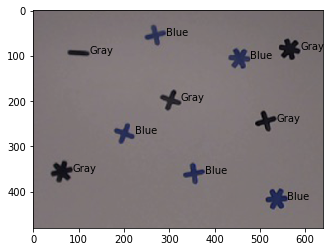

In [51]:
plt.imshow(image)
for ind in range(len(regions)):
    region_pixels = regions[ind]
    Y, X = zip(*region_pixels)
    plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
plt.show()

Oui!

Now let's build the whole pipeline and test it on each image

In [52]:
def pipeline(image):
    grayscale = rgb2gray(image) * 255
    edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection
    
    square_size = [5, 10, 20, 30, 40, 50]
    mask_similarity_threshold = 0.999

    shapes_mask = closing(edges, selem=square(square_size[0]))
    for size in square_size[1:]:
        new_shapes_mask = closing(edges, selem=square(size))
        if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
            break
        shapes_mask = new_shapes_mask
    
    regions = region_growing(shapes_mask)
    
    region_colors = np.zeros(shape=(len(regions), 3))

    for ind, region in enumerate(regions):
        pixel_values = np.array([image[pixel] for pixel in region])
        region_colors[ind, :] = pixel_values.mean(axis=0)
        
    region_std = [np.std(color) for color in region_colors]
    mean_std = np.mean(region_std)
    
    region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
    title = f"There are {region_labels.count('Blue')} blue and {region_labels.count('Gray')} gray shapes."
    
    plt.imshow(image)
    plt.title(title)
    for ind in range(len(regions)):
        region_pixels = regions[ind]
        Y, X = zip(*region_pixels)
        plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
    plt.show()

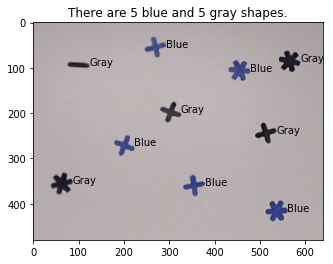

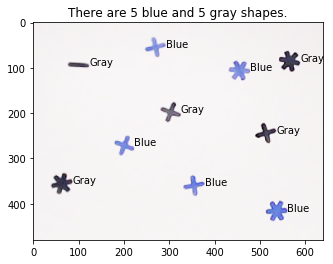

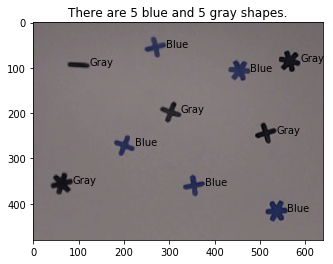

In [53]:
for image in images:
    pipeline(image)

### 2.3 Total area (in pixels) of each color

Our implementation of [task 2.2](#task22) makes it easy to calculate total area of each color.

In [54]:
labels = ['Blue', "Gray"]
label_area = []

for label in labels:
    label_area.append(sum([len(regions[ind]) for ind in range(len(regions)) if region_labels[ind] == label]))
label_area

[6195, 5656]

In [55]:
print(f"There are {label_area[labels.index('Blue')]} blue and {label_area[labels.index('Gray')]} gray pixels.")

There are 6195 blue and 5656 gray pixels.


Let's implement pipeline which from scratch will find interested areas

In [56]:
def pipeline2(image):
    grayscale = rgb2gray(image) * 255
    edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection
    
    square_size = [5, 10, 20, 30, 40, 50]
    mask_similarity_threshold = 0.999

    shapes_mask = closing(edges, selem=square(square_size[0]))
    for size in square_size[1:]:
        new_shapes_mask = closing(edges, selem=square(size))
        if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
            break
        shapes_mask = new_shapes_mask
    
    regions = region_growing(shapes_mask)
    
    region_colors = np.zeros(shape=(len(regions), 3))

    for ind, region in enumerate(regions):
        pixel_values = np.array([image[pixel] for pixel in region])
        region_colors[ind, :] = pixel_values.mean(axis=0)
        
    region_std = [np.std(color) for color in region_colors]
    mean_std = np.mean(region_std)
    
    region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
    
    labels = ['Blue', "Gray"]
    label_area = []

    for label in labels:
        label_area.append(sum([len(regions[ind]) for ind in range(len(regions)) if region_labels[ind] == label]))

    title = f"There are {label_area[labels.index('Blue')]} blue and {label_area[labels.index('Gray')]} gray pixels."
    
    plt.imshow(image)
    plt.title(title)
    for ind in range(len(regions)):
        region_pixels = regions[ind]
        Y, X = zip(*region_pixels)
        plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
    plt.show()

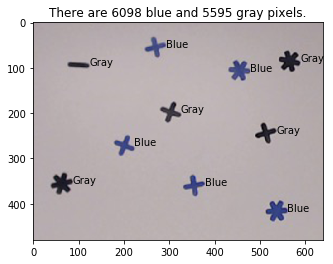

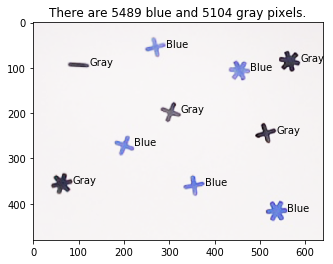

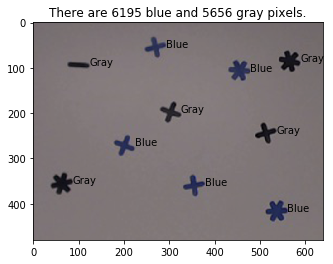

In [57]:
for image in images:
    pipeline2(image)

Different resulting area is due to different size of obtained shapes masks in each case. However, the most affecting on area estimation factor is correctness of shapes labelling. This task is successfully solved!